<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/Spacegroup_specific_endeavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Import
from mp_api.client import MPRester
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from pymatgen.core.structure import Structure
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
import time

In [11]:
# You might need to reinstall the library manually, imports ans pip install:
!pip install mp_api
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# prompt: import csv to pandas df

import pandas as pd
# Assumes you have uploaded 'your_file.csv' using files.upload() or it exists in your runtime
df = pd.read_csv('/content/drive/MyDrive/Project Documents ML-CMT/bandgap_dataset_premium.csv')
df

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.9000,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.0680,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.0680,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.1750,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.7740,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82993,mp-1228901,0.0000,AlAg,6.819246,32.836953,2.926387,2.926387,4.427604,90.000000,90.000000,...,40.443331,1.9750,0.27,2.11,1.84,0.135000,NaN,NaN,NaN,NaN
82994,mp-985805,0.0000,AlAg2,8.170902,98.653158,5.007056,5.007056,4.584863,90.000000,90.000000,...,38.130338,2.0200,0.27,2.11,1.84,0.127279,NaN,NaN,"{'voigt': 94.559, 'reuss': 93.759, 'vrh': 94.159}","{'voigt': 34.496, 'reuss': 32.101, 'vrh': 33.298}"
82995,mp-1228927,0.0000,AlAg3,8.320607,69.966283,2.864708,2.864708,8.982326,90.000000,90.000000,...,35.024952,2.0425,0.27,2.11,1.84,0.116913,NaN,NaN,NaN,NaN
82996,mp-1228988,0.0000,AlAg3,8.683934,335.194847,6.946558,6.946558,6.946558,89.757491,90.242509,...,35.024952,2.0425,0.27,2.11,1.84,0.116913,4.5429,4.5288,NaN,NaN


In [ ]:
df_nonzero = df[df["band_gap"] != 0]
spacegroup_number = 221
number_of_atoms = 5
df_spacegroup = df_nonzero[df_nonzero["spacegroup_number "] == spacegroup_number]
df_spacegroup_atoms = df_spacegroup[df_spacegroup["n_atoms"] == number_of_atoms]
percentage_size = len(df_spacegroup_atoms) / len(df_spacegroup)
size = len(df_spacegroup_atoms)

print(f'''For spacegroup {spacegroup_number}, there are {size} non-zero bandgap materials with {number_of_atoms} atoms in the unit cell,
which is {round(100 * percentage_size, 1)}% of the total non-zero bandgap materials in this spacegroup.''')

For spacegroup 221, there are 217 non-zero bandgap materials with 5 atoms in the unit cell, 
which is 67.0% of the total non-zero bandgap materials in this spacegroup.


In [179]:
with MPRester("VlQ1oWGAXlhWiKRkPOk5q1cP8dNS6mIu") as mpr:
  #Please edit features you want to filter from inside the search() command. for example:
  example_docs = mpr.materials.summary.search(spacegroup_number = 221, num_sites = 5)


Retrieving SummaryDoc documents:   0%|          | 0/1458 [00:00<?, ?it/s]

In [180]:
example_docs[0].band_gap

4.1024

In [115]:
site = example_docs[6].structure.sites[0]

In [116]:
fractional_coords = site.frac_coords
fractional_coords

array([0., 0., 0.])

In [181]:
material_positions_frac = []
material_positions = []
bandgaps = []
for m in example_docs:
  single_material_positions = []
  single_material_frac_positions = []
  for site in m.structure.sites:
    frac_coords = site.frac_coords
    single_material_frac_positions.append(site.frac_coords)
    single_material_positions.append(site.coords)

  material_positions_frac.append(single_material_frac_positions)
  material_positions.append(single_material_positions)
  bandgaps.append(m.band_gap)

In [183]:
all_material = []

for group in material_positions_frac:
  unique_positions = []
  for coord in group:
      # Round to 4 decimal places to eliminate noise
      rounded = tuple(np.round(coord % 1, 4))  # mod 1 ensures coords are in [0, 1)
      unique_positions.append(rounded)
  all_material.append(unique_positions.copy())

In [184]:
df = pd.DataFrame(list(zip(material_positions_frac, material_positions, bandgaps)),
               columns =['all_material', 'material_positions', 'bandgaps'])

In [185]:
df

,all_material,material_positions,bandgaps
0,"[[-0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5,...","[[0.0, 0.0, 0.0], [1.9293169350000001, 1.92931...",4.1024
1,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.860834, 1.860834, 1.86083...",0.8071
2,"[[-0.0, -0.0, -0.0], [0.5, 0.5, 0.5], [0.5, 0....","[[0.0, 0.0, 0.0], [1.97214345, 1.97215113, 1.9...",2.0031
3,"[[0.0, 0.0, 0.0], [0.499998, 0.499998, 0.49999...","[[0.0, 0.0, 0.0], [1.9566577983375, 1.95665779...",0.0000
4,"[[-0.0, 0.0, 0.0], [0.499998999999999, 0.49999...","[[0.0, 0.0, 0.0], [1.9767808564303762, 1.97677...",0.9888
...,...,...,...
1453,"[[0.0, 0.0, 0.0], [-0.0, 0.5, 0.5], [0.5, -0.0...","[[0.0, 0.0, 0.0], [0.0, 2.03775825, 2.03775825...",0.0000
1454,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.8317364999999994, 1.83173...",0.0000
1455,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.9295495, 1.9295495, 1.929...",0.0000
1456,"[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, ...","[[2.106323, 2.106323, 2.106323], [0.0, 0.0, 0....",0.0000


In [213]:
import numpy as np

def find_wyckoff_1b_3c_indices(coords):
    # Normalize and round for matching
    rounded_coords = [tuple(np.round(np.array(c) % 1, 6)) for c in coords]

    wyckoff_1b = (0.5, 0.5, 0.5)
    wyckoff_3c_list = [
        (0.5, 0.5, 0.0),
        (0.5, 0.0, 0.5),
        (0.0, 0.5, 0.5),
    ]

    # Find index of 1b
    try:
        i1b = rounded_coords.index(wyckoff_1b)
    except ValueError:
        i1b = None

    # Find index of any 3c
    i3c = None
    for w3c in wyckoff_3c_list:
        if w3c in rounded_coords:
            i3c = rounded_coords.index(w3c)
            break

    both_found = i1b is not None and i3c is not None

    return i1b, i3c, both_found

In [219]:
distances = []
band_gaps = []
for data in df.values:
  pos1b, pos3c, both = find_wyckoff_1b_3c_indices(data[0])
  if both:
    distance = np.linalg.norm(data[1][pos1b] - data[1][pos3c])
    distances.append(distance)
    band_gaps.append(data[2])


In [220]:
df = pd.DataFrame(list(zip(distances, band_gaps)),
               columns =['distances', 'bandgaps'])

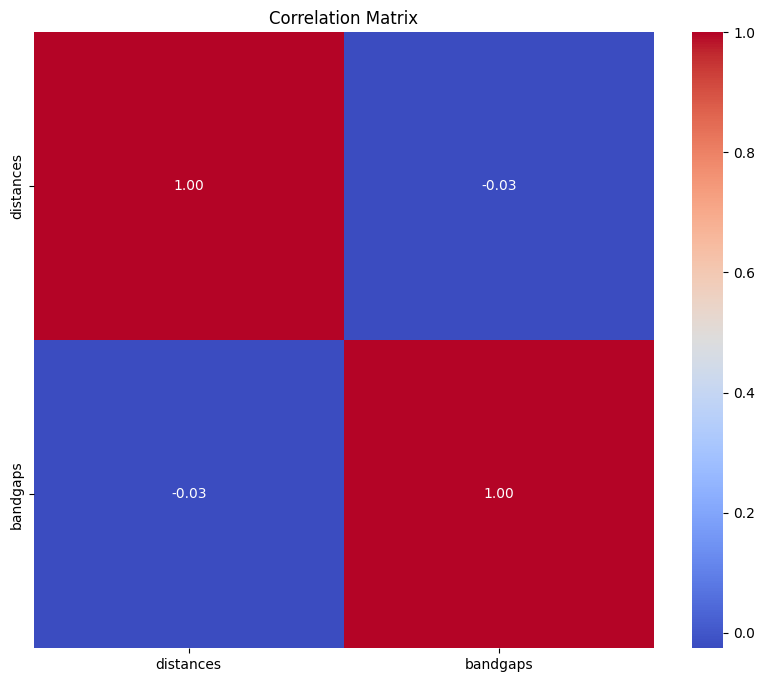

In [226]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [209]:
import numpy as np

def check_wyckoff_1b_3c(coords):
    coords_set = set(tuple(np.round(np.array(c) % 1, 6)) for c in coords)  # rounded to avoid tiny float errors

    # Define exact Wyckoff positions
    wyckoff_1b = (0.5, 0.5, 0.5)
    wyckoff_3c = [
        (0.5, 0.5, 0.0),
        (0.5, 0.0, 0.5),
        (0.0, 0.5, 0.5),
    ]

    found_1b = int(wyckoff_1b in coords_set)
    found_3c = int(all(pos in coords_set for pos in wyckoff_3c))
    return found_1b, found_3c

In [166]:
l_1b = 0
l_3c = 0

for coordinates in all_material:
  wyckoff_1b, wyckoff_3c = check_wyckoff_1b_3c(coordinates)
  l_1b += wyckoff_1b
  l_3c += wyckoff_3c

In [169]:
l_1b, l_3c, len(all_material)

(1434, 1127, 1458)

In [172]:
example_docs[6].structure.distance_matrix

array([[0.        , 3.47818492, 2.8399261 , 2.8399261 , 2.8399261 ],
       [3.47818492, 0.        , 2.008131  , 2.008131  , 2.008131  ],
       [2.8399261 , 2.008131  , 0.        , 2.8399261 , 2.8399261 ],
       [2.8399261 , 2.008131  , 2.8399261 , 0.        , 2.8399261 ],
       [2.8399261 , 2.008131  , 2.8399261 , 2.8399261 , 0.        ]])

In [177]:
example_docs[6].structure.sites

[PeriodicSite: Ac (0.0, 0.0, 0.0) [0.0, 0.0, 0.0],
 PeriodicSite: Mg (2.008, 2.008, 2.008) [0.5, 0.5, 0.5],
 PeriodicSite: O (2.008, 2.008, 0.0) [0.5, 0.5, 0.0],
 PeriodicSite: O (2.008, 0.0, 2.008) [0.5, 0.0, 0.5],
 PeriodicSite: O (0.0, 2.008, 2.008) [0.0, 0.5, 0.5]]